# Projet 1 : Alignement des séquences et programmation dynamique
BAKKALI Yahya : 000445166

# Introduction
En bio-informatique, l'alignement de séquences est une manière de représenter deux ou plusieurs séquences de macromolécules biologiques (ADN, ARN ou protéines) les unes sous les autres, de manière à en faire ressortir les régions homologues ou similaires [1]. Dans le cadre de ce projet on étudiera seulement l'alignement par paires et comment réaliser un alignement optimal entre deux séquences de protéines en utilisant la programmation dynamique comme méthode parmi les autres méthodes existantes. La programmation dynamique consiste à résoudre un problème en le décomposant en sous-problèmes, puis à résoudre les sous-problèmes, des plus petits aux plus grands en stockant les résultats intermédiaires [2]. La visualisation des régions de similarités obtenues par l'alignement des séquences permet d'identifier si elles sont la conséquence de la même fonctionnalité ou de la même structure de domaine ou plutôt une relation évolutive entre les deux séquences. Il y en a deux types d'alignement un global qui se restreint sur la totalité de la longueur des deux séquences et l'autre local qui se focalise seulement sur des segments limités de la séquence où le taux de similarité est fort par rapport à la totalité de la séquence. Parmi les algorithmes réalisés pour obtenir les alignements optimaux on trouve deux trop connue celui de Needleman-Wunsch qui réalise l'alignement global et l'autre de Smith-Waterman qui réalise l'alignement local. Le meilleur alignement des séquences correspond au meilleur score possible de correspondance entre deux séquences, les matrices de substitution permettent de calculer ce score. Les matrices de substitution sont des matrices utilisées en bioinformatique pour réaliser des alignements de séquences biologiques reliées évolutivement. Elles permettent de donner un score de similarité ou de ressemblance entre deux acides aminés [3].Il existe plusieurs de ces matrices, basées sur des principes de construction différents. Par exemple la matrice __PAM__ est base sur les mutations observées dans un alignement global avec la conservation des régions mutables tandis que la matrice __BLOSUM__ n'est fondée que sur des segments spécifiques dans la séquence sans l'introduction des trous. Le numéro de PAM indique la divergence entre les séquences et le numéro de BLOSUM indique le pourcentage d'identité.

# Matériel & Méthodes
Pour la réalisation de ce projet on utilisera Python3 comme langage de programmation et des jeux données pour tester et évaluer les algorithmes d'alignement :
1. Deux types de matrices de substitution __PAM__ et __BLOSUM__ stockée dans des fichiers textes blosum62, blosum80,pam60,pam120.
2. Deux séquences au format FASTA __WW-squence.fasta__ pour le global alignement et __protein-sequences.fasta__ pour le local alignement. 

Avant l'extraction des données à partir des fichiers fournies on a besoin du certaines structures pour les stocker.<br> Pour cela on va créer deux ADT(Abstract Data Type) un pour la séquence des acides amines et l'autre pour les matrices de scores et de substitutions.

In [1]:
class ADTsequence(object):

    def __init__(self, sequence):
        self.sequence = sequence

    def __getitem__(self, key):
        return self.sequence[key]

    def __len__(self):
        return len(self.sequence)

    def __str__(self):
        output = ""
        for i in range(len(self) // 60 + 1):
            output += self.sequence[i * 60:(i + 1) * 60]
            output += "\n"
        return output[:-1]

ADTsequence est un ADT qui représente une séquence d’acides aminés et toutes les opérations qu’on peut exécuter sur une séquence qui sont nécessaires pour l’implémentation d’algorithme d’alignement (p.ex. retourner un acide aminé à une certaine position ou visualiser la séquence en format FASTA).

In [2]:
class ADTmatrix:

    def __init__(self, n=None, m=None):
        
        self.n = n
        self.m = m

        if n and m:
            self.matrix = [[0 for i in range(m)] for j in range(n)]
        else:
            self.matrix = []

    def getItem(self, i, j):
        return self.matrix[i][j]

    def setItem(self, i, j, value):
        self.matrix[i][j] = value

    def maxValue(self):

        x, y = 1, 1
        maximum = self.getItem(x, y)
        for i in range(1, self.n):
            for j in range(1, self.m):
                if maximum < self.getItem(i, j):
                    maximum = self.getItem(i, j)
                    x, y = i, j
        return x, y
        
    def addRow(self, row):
        self.matrix.append(row)

    def __str__(self):
        output = ""
        for i in range(len(self.matrix)):
            for j in range(len(self.matrix[0])):
                output += str(self.matrix[i][j])
                output += " "
            output += "\n"
        return output[:-1]

ADTmatrix est un ADT qui représente une matrice et les opérations qu’on peut exécuter sur cette matrice.Il sera utiliser pour créer des sous-classes matrice, pour la matrice de substitution et pour les matrices scores que nous utiliserons lors de l’implémentation de l’algorithme d’alignement de séquences.

In [3]:
class SubstitutionMatrix(ADTmatrix):

    def __init__(self, n=None, m=None):
        super().__init__(n, m)
        self.myList = []

    def __getitem__(self, key):
        return self.myList.index(key)

    def Append(self, value):
        self.myList.append(value)

SubstitutionMatrix est une sous-classe de la classe ADTmatrix dans laquelle on stockera les matrices de substitution qui seront utilisé après dans les algorithmes d'alignement.

In [4]:
def SequencesParser(filename):
    f = open(filename, encoding='utf-8')
    mylist = []
    sequence = ''
    for line in f:
        if line[0] not in [">", " ", "\n"]:
            sequence += line.strip("\n")
        elif len(sequence) :
            mylist.append(ADTsequence(sequence))
            sequence = ''
    if len(sequence) :
        mylist.append(ADTsequence(sequence))
    f.close()
    return mylist

sequenceParser un parser qui peut lire des fichiers avec des séquences (en format FASTA) et qui enregistre chaque séquence comme une instance de l’ADTsequence.

In [5]:
def MatrixParser(filename):
    f = open(filename, encoding='utf-8')
    matrix = SubstitutionMatrix()
    for line in f:
        if line[0] not in ["#", " ", "\n"]:
            matrix.Append(line[0])
            matrix.addRow(line[1:].split())
    f.close()
    return matrix

MatrixParser un parser qui peut lire des fichiers qui représentent des matrices de substitution et qui enregistre chaque
matrice comme une instance de l’ADT substitution matrix.

In [6]:
GLOBALsequences = SequencesParser("WW-sequence.fasta")
LOCALsequences = SequencesParser("protein-sequences.fasta")
pam120 = MatrixParser("pam120.txt")
pam60 = MatrixParser("pam60.txt")
blosum80 = MatrixParser("blosum80.txt")
blosum62 = MatrixParser("blosum62.txt")


Extraction des données et l'initialisation des différentes matrices de substitutions.

In [7]:
class ScoringMatrix(ADTmatrix):

    def __init__(self, character, mode, sequence1, sequence2, I=None, E=None):
        super().__init__(len(sequence1) + 1, len(sequence2) + 1)
        self.sequence1 = sequence1
        self.sequence2 = sequence2
        self.n = len(sequence1) + 1
        self.m = len(sequence2) + 1

        if character == "V":
            self.initV()
        elif character == "W":
            self.initW()
        else:
            self.initS(mode, I, E)

    def initS(self, mode, I, E):

        for i in range(1, self.m):
            gap = - I - (i - 1) * E
            if mode == "LOCAL":
                self.setItem(0, i, max(0, gap))
            else:
                self.setItem(0, i, gap)

        for j in range(1, self.n):
            gap = - I - (j - 1) * E
            if mode == "LOCAL":
                self.setItem(j, 0, max(0, gap))
            else:
                self.setItem(j, 0, gap)

    def initV(self):
        for i in range(self.m):
            self.setItem(0, i, - float("inf"))

        for j in range(1, self.n):
            self.setItem(j, 0, 0)

    def initW(self):
        for i in range(1, self.m):
            self.setItem(0, i, 0)

        for j in range(self.n):
            self.setItem(j, 0, - float("inf"))

ScoringMatrix est une sous-classe de la classe ADTmatrix qui permet de créer trois types d'instance différentes S, V, W. Les matrices V et W ont comme rôle de retenir les pénalités où un trou a déjà été initialisé tandis que S est la matrice utilisée pour construire le parcours. V et W sont initialisé de la façon que chaque matrice respecte ces deux formes respectivement :

|      |      | S    | E    | Q    | 2    |                            
|------|------|------|------|------|------|
|      | -inf | -inf | -inf |-inf  |-inf  |
|   S  | 0    |      |      |      |      |
|   E  | 0    |      |      |      |      |
|   Q  | 0    |      |      |      |      |
|   1  | 0    |      |      |      |      |

                                                      La matrice V
                                                      
|      |      | S    | E    | Q    | 2    |                            
|------|------|------|------|------|------|
|      | -inf | 0    | 0    | 0    | 0    |
|   S  | -inf |      |      |      |      |
|   E  | -inf |      |      |      |      |
|   Q  | -inf |      |      |      |      |
|   1  | -inf |      |      |      |      |

                                                      La matrice W

Par contre pour initialiser la matrice S faut préciser dans quel alignement il sera utilise local ou global parce que dans l'alignement local les valeurs négatives sont remplacées par des zéros. On remplit chaque case par la valeur du gap affine en utilisant la formule suivante $ g(n_{gap}) = - I - (n_{gap} - 1) E $ ou __I__ référence l'insertion du gap et __E__ l'extension du gap.

In [8]:
class NeedlemanWunsch(object):
    def __init__(self, S, V, W, MATSUB, k, I, E):

        self.S = S
        self.V = V
        self.W = W
        self.MATSUB = MATSUB
        self.k = k
        self.I = I
        self.E = E
        self.solutionCounter = 0
        self.similarityRate = 0

        for i in range(1, self.S.n):
            for j in range(1, self.S.m):
                self.fill(i, j)
        self.findAlignment()


    def t(self, i, j):
        x = self.MATSUB[self.S.sequence2[j - 1]]
        y = self.MATSUB[self.S.sequence1[i - 1]]
        return int(self.MATSUB.getItem(x, y))

    def fill(self, i, j):

        self.V.setItem(i, j, max(self.S.getItem(i - 1, j) - self.I, self.V.getItem(i - 1, j) - self.E))
        self.W.setItem(i, j, max(self.S.getItem(i, j - 1) - self.I, self.W.getItem(i, j - 1) - self.E))
        self.S.setItem(i, j, max(self.S.getItem(i - 1, j - 1) + self.t(i, j), self.V.getItem(i,j), self.W.getItem(i,j)))
    
    def getSimilarityRate(self) :
        return self.similarityRate

La classe NeedlemanWunsch est une implémentation de l'algorithme de Needleman-Wunsch qui est un algorithme qui effectue un alignement global entre deux séquences de protéines en utilisant la programmation dynamique. On lui donne en entrée les trois matrices du score S, V et W qui sont initialisés en plus de la matrice de substitution avec les paramètres I et E qu'on veut exécuter l'algorithme avec et il retourne en sortie k alignement globaux possible pour les deux séquences qu'on veut aligner. 

La première étape de l'algorithme est de remplir les matrices de scores S, V et W en utilisant les 3 formules ci-dessous:

$$
V(i,j) = max
    \left \{
       \begin{array}{l}
          S(i-1,j)-I \\
          W(i-1,j)-E
       \end{array}
       \right .
$$

$$
W(i,j) = max
    \left \{
       \begin{array}{l}
          S(i,j-1)-I \\
          W(i,j-1)-E
       \end{array}
       \right .
$$

$$
S(i,j) = max
    \left \{
       \begin{array}{l}
          S(i-1,j-1)+t(i,j) \\
          V(i,j) \\
          W(i,j)
       \end{array}
       \right .
$$

La fonction V renvoie la valeur maximale entre l'insertion d'un nouvel espace dans la séquence horizontale et l'extension des espaces dans la séquence verticale.

La fonction W renvoie la valeur maximale entre l'insertion d'un nouvel espace dans la séquence verticale et l'extension des espaces dans la séquence horizontale. 

La fonction S renvoie le maximum entre le match des deux acides amines en utilisant la valeur stocke dans la matrice de substitution et les résultats obtenus auparavant par les deux fonctions V et W à la même position $(i, j)$ .

Dans la classe c'est la méthode fill(i, j) qui s'occupe de remplir les matrices comme c'est expliqué au-dessus et la méthode t(i, j) renvoie la valeur du match entre les deux acides amines

In [9]:
class NeedlemanWunsch(NeedlemanWunsch):
        
    def findAlignment(self, i=None, j=None,seq = "",seq2 = "",seq3 = ""):
        if i is None and j is None:
            i = self.S.n - 1
            j = self.S.m - 1
        if i >= 0 and j >= 0 and self.solutionCounter < self.k :
            if i == 0 and j == 0:
                self.solutionCounter += 1
                self.similarityRate = round((seq3.count("|") + seq3.count(":")) / len(seq3) * 100,2)
                show(self.solutionCounter,self.S.getItem(self.S.n - 1, self.S.m - 1), seq[::-1], seq2[::-1], seq3[::-1])

            else:

                if self.S.getItem(i, j) == self.S.getItem(i - 1, j - 1) + self.t(i, j):
                    seq += self.S.sequence1[i - 1]
                    seq2 += self.S.sequence2[j - 1]
                    if self.S.sequence1[i - 1] == self.S.sequence2[j - 1]:
                        seq3 += "|"
                    else:
                        seq3 += ":" if self.t(i, j) >= 0 else "."
                    self.findAlignment(i - 1, j - 1,seq,seq2,seq3)
                    seq = seq[:-1]
                    seq2 = seq2[:-1]
                    seq3 = seq3[:-1]

                if self.S.getItem(i, j) == self.V.getItem(i, j) or j == 0:
                    seq += self.S.sequence1[i - 1]
                    seq2 += "-"
                    seq3 += " "
                    self.findAlignment(i - 1, j,seq,seq2,seq3)
                    seq = seq[:-1]
                    seq2 = seq2[:-1]
                    seq3 = seq3[:-1]

                if self.S.getItem(i, j) == self.W.getItem(i, j) or i == 0:
                    seq += "-"
                    seq2 += self.S.sequence2[j - 1]
                    seq3 += " "
                    self.findAlignment(i, j - 1,seq,seq2,seq3)
                    seq = seq[:-1]
                    seq2 = seq2[:-1]
                    seq3 = seq3[:-1]

Après le remplissage des trois matrices, l'algorithme débute la deuxième phase qui consiste à trouver l'alignement optimal entre les deux séquences de protéines. L'idée de cette phase est de trouver tous les alignements possibles qui ont le même meilleur score, pour cela on commence à la position $ (n, m) $ qui correspond a la derniere case de la matrice S qui contient la valeur maximale qu'on peut obtenir pour un alignement entre ces deux séquences puis en essaye de remonter jusqu'à ce qu'on arrive à la valeur 0 qui se trouvait a la position $ (0,0) $ de la matrice du score S. En remontant la décision d'aller à gauche, en haut ou en diagonale depend d'où vient la valeur à cette position. Si la valeur vient du V on insère un gap dans la séquence horizontale s'il vient du W on l'insert dans la séquence verticale sinon la valeur vient du match et donc on ne fait rien. À un moment donné la valeur peut-être obtenue à partir des deux ou les trois matrices mais on donne toujours la priorité au match parce que c'est plus preferable que d'introduire un gap.

In [10]:
class SmithWaterman(object):
    def __init__(self, S, V, W, MATSUB, l, I, E):

        self.S = S
        self.V = V
        self.W = W
        self.MATSUB = MATSUB
        self.I = I
        self.E = E
        self.indexList = []

        for i in range(1, self.S.n):
            for j in range(1, self.S.m):
                self.fill(i, j)

        i = 0
        while i < l and sum([sum(row) for row in self.S.matrix]):
            self.indexList = []
            self.topDown(i+1)
            self.fillZero()
            self.computeAgain()
            i += 1

    def t(self, i, j):
        x = self.MATSUB[self.S.sequence2[j - 1]]
        y = self.MATSUB[self.S.sequence1[i - 1]]
        return int(self.MATSUB.getItem(x, y))

    def fill(self, i, j):

        self.V.setItem(i, j, max(0, self.S.getItem(i - 1, j) - self.I, self.V.getItem(i - 1, j) - self.E))
        self.W.setItem(i, j, max(0, self.S.getItem(i, j - 1) - self.I, self.W.getItem(i, j - 1) - self.E))
        self.S.setItem(i, j, max(0, self.S.getItem(i - 1, j - 1) + self.t(i, j), self.V.getItem(i,j), self.W.getItem(i,j)))

La classe SmithWaterman est une implémentation de l'algorithme de Smith-Waterman qui est un algorithme qui effectue un alignement local entre deux séquences de protéines en utilisant la programmation dynamique. On lui donne en entrée les trois matrices du score S, V et W qui sont initialisés en plus de la matrice de substitution avec les paramètres I et E qu'on veut exécuter l'algorithme avec et il retourne en sortie l alignement locaaux possible pour les deux séquences qu'on veut aligner. 

La première étape de l'algorithme est de remplir les matrices de scores S, V et W en utilisant les 3 formules ci-dessous:

$$
V(i,j) = max
    \left \{
       \begin{array}{l}
          S(i-1,j)-I \\
          W(i-1,j)-E \\
          0
       \end{array}
       \right .
$$

$$
W(i,j) = max
    \left \{
       \begin{array}{l}
          S(i,j-1)-I \\
          W(i,j-1)-E \\
          0
       \end{array}
       \right .
$$

$$
S(i,j) = max
    \left \{
       \begin{array}{l}
          S(i-1,j-1)+t(i,j) \\
          V(i,j) \\
          W(i,j) \\
          0
       \end{array}
       \right .
$$

Les trois fonctions ont le même fonctionnement que celles dans l'alignement global cependant il y a seulement une petite différence par rapport à avant c'est que si la valeur renvoyer et négatifs on la remplace par zéro.

In [11]:
class SmithWaterman(SmithWaterman):
    def topDown(self, number):

        i, j = self.S.maxValue()
        self.indexList.append((i, j))
        score = self.S.getItem(i, j)
        seq = ""
        seq2 = ""
        seq3 = ""
        pos = (i,j)
        while self.S.getItem(i, j):

            value = self.S.getItem(i, j)
            pos2 = (i,j)

            if value == self.S.getItem(i - 1, j - 1) + self.t(i, j):
                seq += self.S.sequence1[i - 1]
                seq2 += self.S.sequence2[j - 1]
                if self.S.sequence1[i - 1] == self.S.sequence2[j - 1]:
                    seq3 += "|"
                else:
                    seq3 += ":" if self.t(i, j) >= 0 else "."
                i, j = i - 1, j - 1

            elif value == self.V.getItem(i, j):
                seq += self.S.sequence1[i - 1]
                seq2 += "-"
                seq3 += " "
                i = i - 1

            elif value == self.W.getItem(i, j):
                seq += "-"
                seq2 += self.S.sequence2[j - 1]
                seq3 += " "
                j = j - 1

            self.indexList.append((i, j))

        show(number, score, seq[::-1], seq2[::-1], seq3[::-1],pos,pos2)
        self.indexList.pop()

Pour l'alignement local on procède différemment par rapport au global, on ne commence pas à partir de $ (i, j) $ mais à partir de la position de la plus grande valeur de la matrice du score S et s'il y en a plusieurs valeurs maximales on peut prendre n'importe laquelle la seule chose qui va changer c'est juste l'ordre dans lequel notre résultat est obtenu.
Donc la methode maxValue() nous renvoie la position de la valeur maximale de la matrice du score et c'est a partir de cette position qu'on va commencer a construire notre alignement on faisant la meme chose qu'on a fait dans l'alignement global sauf que cette fois ci on s'arrete des qu'on rencontre une valeur 0.

La méthode topDown() remplie a chaque fois une liste avec les positions du chemin construit pour l'alignement et affiche à la fin cette alignement. Cette liste d'indices sera indispensable pour la suite. 

In [12]:
class SmithWaterman(SmithWaterman):
    def fillZero(self):

        for elem in self.indexList:
            self.S.setItem(elem[0], elem[1], 0)
            self.V.setItem(elem[0], elem[1], 0)
            self.W.setItem(elem[0], elem[1], 0)

Dès qu'on a notre liste des indices on fait appel à la méthode fillzero() qui va mettre à zéro les valeurs des matrices du score S, V et W à chaque position $ (i, j) $ de l’alignement optimal qui se trouve dans la liste. Cette étape est primordiale pour trouver le prochain alignement entre les autres régions.

In [13]:
class SmithWaterman(SmithWaterman):
    def computeAgain(self):
        i, j = self.indexList[-1]
        while i < self.S.n:
            while j < self.S.m:
                if self.S.getItem(i,j) > 0 or self.V.getItem(i,j) > 0 or self.W.getItem(i,j) > 0:
                    self.fill(i, j)
                j += 1
            i += 1
            j = self.indexList[-1][1]

Après avoir remplacé les valeurs par des zéros on utilise la méthode computeAgain() qui recalculera toute ce qui se trouve en bas et à gauche de la position $(i, j)$ dans les trois matrices du score S, V et W ou $ (i, j) $ représente la dernière position ajoutée dans la liste des positions. Sauf qu'il faut garder les valeurs mises auparavant à zéro  et ne les pas recalculer.

In [14]:
def show(number, score, sequence, sequence2, sequence3, pos=None, pos2=None):
    print("Soluntion n°: {0} ".format(number))
    w = (len(sequence) // 60 + 1) if len(sequence) % 60 != 0 else len(sequence) // 60
    if pos is not None and pos2 is not None :
        from_ = pos2[0] - 1
        from__ = pos2[1] - 1
    for i in range(w):
        if pos is None and pos2 is None :
            print(sequence[i * 60:(i + 1) * 60] \
                + "\n" + sequence3[i * 60:(i + 1) * 60] \
                + "\n" + sequence2[i * 60:(i + 1) * 60] + "\n")
        else :
            taille = len(sequence[i * 60:(i + 1) * 60]) - sequence[i * 60:(i + 1) * 60].count("-")
            taille_ = len(sequence2[i * 60:(i + 1) * 60]) - sequence2[i * 60:(i + 1) * 60].count("-")
            to_  = from_ + taille
            to__  = from__ + taille_
            print(sequence[i * 60:(i + 1) * 60] \
                + " - from {0} to {1}".format(from_,to_) \
                + "\n" + sequence3[i * 60:(i + 1) * 60] \
                + "\n" + sequence2[i * 60:(i + 1) * 60] \
                + " - from {0} to {1}".format(from__,to__) + "\n")

            from_ = to_
            from__ = to__
            
    print("Score :", score)
    print("Identity percentage :", round(sequence3.count("|") / len(sequence3) * 100,2), "%")
    print("Similarity rate:", round((sequence3.count("|") + sequence3.count(":")) / len(sequence3) * 100,2), "%")
    print("-" * 60)

# Résultats & Discussions
## Alignement global
Pour tester l'algorithme implémenté au-dessus on utilisera des séquences du fichier __WW-sequence.fasta.__ qu'on a déjà extrait avec notre parser. Pour ce test on utilisera comme paramètre  I = 8 et E = 2 avec les deux matrices des substitutions PAM60 et PAM120 mais on affichera juste le classement obtenu par une de ces deux matrices. Ce classement est basé sur le taux de la similarité qui nous montre lesquelles de ces séquences sont les plus similaires. En jouant un peu avec le paramètre I et les deux matrices PAM60 et PAM120 on observe que le classement change surtout quand on fait un saut de 4 à 8 ou 12 et qu'on utilise les deux matrices mais par contre en gardant la même matrice et changer la valeur de I aux alentours de 12 on constate que le classement reste intact et c'est juste les taux de similarité qui subissent des petits changements.

Le classement des alignements des séquences WW permet facilement de trouver lesquelles de ces séquences sont les plus similaires, dans notre exemple on voit bien que la séquence 2 __(>sp|P46934|610-643)__ et 3 __(>sp|P46934|892-925)__ ont à un taux de similarité de __80%__ et en regardant sur le site UniProt on voit que ces deux séquences viennent de la même protéine __E3 ubiquitin-protein ligase NEDD4__ et aussi du même domaine __WW__ et puis il y a la séquence 3 __(>sp|P46934|892-925)__ et 4 __>sp|Q13526|5-39__ avec un taux de similarité qui dépasse le __74%__ qui
viennent de protéines différentes __E3 ubiquitin-protein ligase NEDD4__ et __Peptidyl-prolyl cis-trans isomerase NIMA-interacting 1__ mais du même domaine __WW__. Donc on peut conclure que le fait d'avoir un taux de similarité élevé revient au fait que les trois séquences appartient à l'être humain.

Alignment between sequence 1 and 2 

Soluntion n°: 1 
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK
.|||:|||..:...|:.|::||.::.|.|:.|..
SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP

Score : 62
Identity percentage : 38.24 %
Similarity rate: 61.76 %
------------------------------------------------------------
Alignment between sequence 1 and 3 

Soluntion n°: 1 
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK
.|||:|||....::|:.:::||..:.|.|:|||.
GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL

Score : 76
Identity percentage : 41.18 %
Similarity rate: 67.65 %
------------------------------------------------------------
Alignment between sequence 1 and 4 

Soluntion n°: 1 
VPLPAGWE--MAKTSSGQRYFLNHIDQTTTWQDPRK
..||:|||  |:: |||:.|::|||.:::.|:.|..
EKLPPGWEKRMSR-SSGRVYYFNHITNASQWERPSG

Score : 73
Identity percentage : 41.67 %
Similarity rate: 69.44 %
------------------------------------------------------------
Alignment between sequence 1 and 5 

Soluntion n°: 1 
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK
....:.|...|:::|:.|:.|...:.:||:.|..
SGAKSMWTE

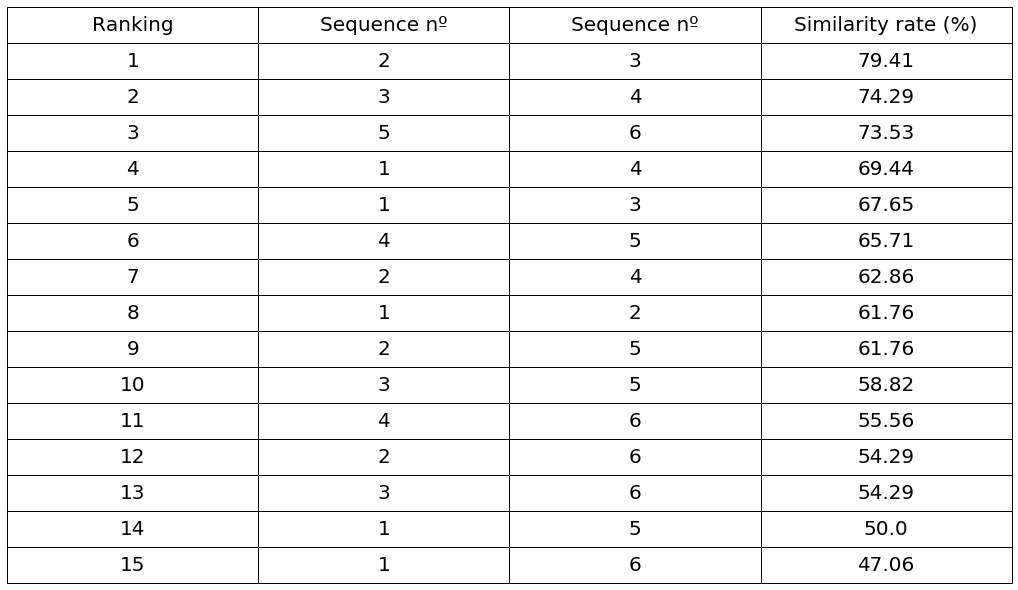

In [15]:
I = 8
E = 2
k = 1
rankingList = []
for i in range(len(GLOBALsequences)):
    for j in range(i+1,len(GLOBALsequences)) :
        print("Alignment between sequence {0} and {1} \n".format(i+1,j+1))
        S = ScoringMatrix("S","GLOBAL",GLOBALsequences[i],GLOBALsequences[j],I,E)
        V = ScoringMatrix("V","GLOBAL",GLOBALsequences[i],GLOBALsequences[j])
        W = ScoringMatrix("W","GLOBAL",GLOBALsequences[i],GLOBALsequences[j])
        similarityRate = NeedlemanWunsch(S,V,W,pam120,k,I,E).getSimilarityRate()
        
        if len(rankingList) == 0 :
            rankingList.append([i+1,j+1,similarityRate])
        else :
            inserted = False
            z = 0
            while not inserted and z < len(rankingList):
                if rankingList[z][2] < similarityRate :
                    rankingList.insert(z,[i+1,j+1,similarityRate])
                    inserted = True
                z += 1
            if not inserted :
                rankingList.append([i+1,j+1,similarityRate])

%matplotlib inline
import matplotlib.pyplot as plt
fig, axs =plt.subplots()
celltext =  [[i+1] + rankingList[i] for i in range(15)]
collabel=("Ranking", "Sequence nº", "Sequence nº","Similarity rate (%)")
axs.set_axis_off()
rankingTable = plt.table(cellText=celltext, colLabels=collabel,loc='center',cellLoc='center')
rankingTable.auto_set_font_size(False)
rankingTable.set_fontsize(20)
rankingTable.scale(3, 3)
plt.show()

### Comparaison avec LALIGN
Le tableau ci-dessous contient les différents résultats obtenus pour chaque combinaison possible de deux séquences parmi les séquences des protéines disponibles avec l'utilisation des matrices de la substitution PAM60, PAM120 et PAM120 du site LALIGN pour les paramètres I = 8 et E = 2.

Entre les valeurs obtenues par PAM60 et PAM120 on voit bien que pour le score et le taux de similarités la majorité de valeurs de PAM60 sont inférieures aux valeurs de PAM12 par contre le taux d'identité pour PAM60 est toujours supérieurs ou égaux aux valeurs de PAM120.

En ce qui concerne la comparaison entre nos valeurs de PAM120 avec les valeurs de LALIGN pour la même matrice, on arrive presque au mêmes résultats avec une légère différence du score qui est dû au fait que nous utilisons une méthode simplifiée avec trois matrices deux pour les gaps et une pour conserver les scores optimaux, or la méthode complète plus complexe utilise 4 matrices.

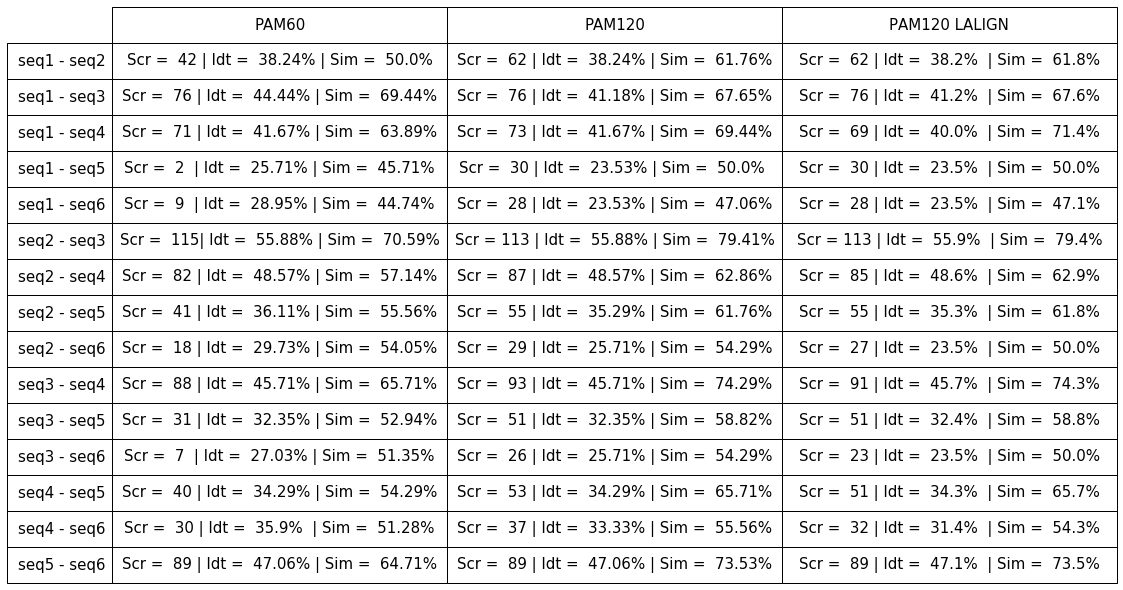

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs =plt.subplots()
col_labels = ["PAM60", "PAM120", "PAM120 LALIGN"]
row_labels = ["seq1 - seq2", "seq1 - seq3", "seq1 - seq4", "seq1 - seq5", "seq1 - seq6", 
              "seq2 - seq3", "seq2 - seq4", "seq2 - seq5", "seq2 - seq6",
              "seq3 - seq4", "seq3 - seq5", "seq3 - seq6",
              "seq4 - seq5", "seq4 - seq6",
              "seq5 - seq6"]

table_vals = [["Scr =  42 | Idt =  38.24% | Sim =  50.0%" , "Scr =  62 | Idt =  38.24% | Sim =  61.76%", "Scr =  62 | Idt =  38.2%  | Sim =  61.8%"],
              ["Scr =  76 | Idt =  44.44% | Sim =  69.44%", "Scr =  76 | Idt =  41.18% | Sim =  67.65%", "Scr =  76 | Idt =  41.2%  | Sim =  67.6%"],
              ["Scr =  71 | Idt =  41.67% | Sim =  63.89%", "Scr =  73 | Idt =  41.67% | Sim =  69.44%", "Scr =  69 | Idt =  40.0%  | Sim =  71.4%"],
              ["Scr =  2  | Idt =  25.71% | Sim =  45.71%", "Scr =  30 | Idt =  23.53% | Sim =  50.0% ", "Scr =  30 | Idt =  23.5%  | Sim =  50.0%"],
              ["Scr =  9  | Idt =  28.95% | Sim =  44.74%", "Scr =  28 | Idt =  23.53% | Sim =  47.06%", "Scr =  28 | Idt =  23.5%  | Sim =  47.1%"],
              ["Scr =  115| Idt =  55.88% | Sim =  70.59%", "Scr = 113 | Idt =  55.88% | Sim =  79.41%", "Scr = 113 | Idt =  55.9%  | Sim =  79.4%"],
              ["Scr =  82 | Idt =  48.57% | Sim =  57.14%", "Scr =  87 | Idt =  48.57% | Sim =  62.86%", "Scr =  85 | Idt =  48.6%  | Sim =  62.9%"],
              ["Scr =  41 | Idt =  36.11% | Sim =  55.56%", "Scr =  55 | Idt =  35.29% | Sim =  61.76%", "Scr =  55 | Idt =  35.3%  | Sim =  61.8%"],
              ["Scr =  18 | Idt =  29.73% | Sim =  54.05%", "Scr =  29 | Idt =  25.71% | Sim =  54.29%", "Scr =  27 | Idt =  23.5%  | Sim =  50.0%"],
              ["Scr =  88 | Idt =  45.71% | Sim =  65.71%", "Scr =  93 | Idt =  45.71% | Sim =  74.29%", "Scr =  91 | Idt =  45.7%  | Sim =  74.3%"],
              ["Scr =  31 | Idt =  32.35% | Sim =  52.94%", "Scr =  51 | Idt =  32.35% | Sim =  58.82%", "Scr =  51 | Idt =  32.4%  | Sim =  58.8%"],
              ["Scr =  7  | Idt =  27.03% | Sim =  51.35%", "Scr =  26 | Idt =  25.71% | Sim =  54.29%", "Scr =  23 | Idt =  23.5%  | Sim =  50.0%"],
              ["Scr =  40 | Idt =  34.29% | Sim =  54.29%", "Scr =  53 | Idt =  34.29% | Sim =  65.71%", "Scr =  51 | Idt =  34.3%  | Sim =  65.7%"],
              ["Scr =  30 | Idt =  35.9%  | Sim =  51.28%", "Scr =  37 | Idt =  33.33% | Sim =  55.56%", "Scr =  32 | Idt =  31.4%  | Sim =  54.3%"],
              ["Scr =  89 | Idt =  47.06% | Sim =  64.71%", "Scr =  89 | Idt =  47.06% | Sim =  73.53%", "Scr =  89 | Idt =  47.1%  | Sim =  73.5%"]]
the_table = plt.table(cellText=table_vals, rowLabels=row_labels, colLabels=col_labels, loc='center', cellLoc='center')
axs.set_axis_off()
the_table.auto_set_font_size(False)
the_table.set_fontsize(15)
the_table.scale(3, 3)
plt.show()

In [17]:
I = 8
E = 2
l = 1
for i in range(len(LOCALsequences)):
    for j in range(i+1,len(LOCALsequences)) :
            print("Alignment between sequence {0} and {1} \n".format(i+1,j+1))
            S = ScoringMatrix("S","LOCAL",LOCALsequences[i],LOCALsequences[j],I,E)
            V = ScoringMatrix("V","LOCAL",LOCALsequences[i],LOCALsequences[j])
            W = ScoringMatrix("W","LOCAL",LOCALsequences[i],LOCALsequences[j])
            SmithWaterman(S, V, W, blosum62, l, I, E)

Alignment between sequence 1 and 2 

Soluntion n°: 1 
VSPGTLTPTGVVSGP---AAT-PTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNH - from 136 to 192
|:.:.||.:...:||   |:| .::|::.|.| ||.:.. ||.|||:..:.:|:.:|::|
VETSQLTSSQSSAGPQSQASTSDSGQQVTQPS-EIEQGF-LPKGWEVRHAPNGRPFFIDH - from 803 to 861

IDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHK - from 192 to 252
..:||||:|||      :::.|.....::.:..|:. ||||.|||:....||:|:||||:
NTKTTTWEDPR------LKIPAHLRGKTSLDTSNDL-GPLPPGWEERTHTDGRIFYINHN - from 861 to 914

NKTTSWLDPRLD - from 252 to 264
.|.|:|.||||:
IKRTQWEDPRLE - from 914 to 926

Score : 214
Identity percentage : 37.88 %
Similarity rate: 62.12 %
------------------------------------------------------------
Alignment between sequence 1 and 3 

Soluntion n°: 1 
QGQPPSQ-PPQGQGPPSGPG--QPAPAATQA-APQAPPAGHQIVHVRGDSETDLEALFNA - from 15 to 71
:::|||| |.:|:...||.:  :.:.::::: ..:.|..||..:|....:...:....|.
ESHPPSQGPGDGERRLSGSSLCSGSWVSADGFLRRRPSMGHPGMHYAPMGMHPMGQRANM - from 17 to 77

VMNPKTANVPQTV-PM---RLRKLPD--SFFK

Alignment between sequence 3 and 4 

Soluntion n°: 1 
WTEHKS-PDGRTYYYNTETKQSTWEKP----DDL-KT-PAEQLLSKCPWKEYK-SDSGKP - from 145 to 197
|.::.| .:||:||:|..|:.|.||:|    ::. |: .:|....:|.....| |:|.:|
WEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRP - from 10 to 70

YYYNSQTKESRWAKPKELEDLEGYQNTIVAG - from 197 to 228
..:: |.|.:| :|.:.||.::||.:.|.:|
SSWR-QEKITR-TKEEALELINGYIQKIKSG - from 70 to 99

Score : 80
Identity percentage : 31.87 %
Similarity rate: 57.14 %
------------------------------------------------------------
Alignment between sequence 3 and 5 

Soluntion n°: 1 
PMGGPPMGQMPGMMSSVMPGMMMSHMSQASMQPALPPGVNSMDVAAGTASGAKSMWTEHK - from 90 to 150
|.||...|:....:.:.:|:..::.:::.:|.|. |||.:|:.|   ..  ..: |.::.
PDGGWWEGEKEDGLRGWFPASYVQLLEKPGMVPP-PPGEESQTV---IL--PPG-WQSYL - from 34 to 87

SPDGRTYYYNTETKQSTWEKPDDLKTPAEQLLSKCPWKEYKSDSGKPYYYNSQTKESRWA - from 150 to 210
||:||.||.||.|:::|||:| : ::|     : .|.:..:..|:.|...|:...::..|
SPQGRRYYVNTTTNETTWERP-S-SSP-----G-IPASPGSHRSSLPPTVNGYHASGTP

## Alignement local
### Comparaison avec LALIGN
Le tableau ci-dessous contient les différents résultats obtenus pour chaque combinaison possible de deux séquences parmi les séquences des protéines disponibles avec l'utilisation des matrices de la substitution BLOSUM62, BLOSUM80 et les deux autres matrices BLOSUM62 et BLOSUM80 du site LALIGN  pour les paramètres I = 8 et E = 2.

Les valeurs obtenues par BLOSUM62 et BLOSUM62 LALIGN sont fort semblables ou les valeurs de BLOSUM80 et BLOSUM80 LALIGN diffère largement et ça peut-être du a cause de trois facteurs qui sont les paramètres I et E qui ne sont pas les mêmes, l'implementation d'algorithme qui prend en préférence les gaps au lieu du match ou le fait d'utiliser une autre version de la matrice de substitution BLOSUM80. On neglige la possibilité que la différence vienne des paramètres parce qu'on s'est assuré d'utiliser les mêmes donc on vérifie le deuxième cas ou il se trouve qu'il est indiqué sur le site de LALIGN que l'algorithme utilisé est celui de __Huang and Miller__ or le notre est celui de __Needleman-Wunsch__ ou à cause de la matrice BLOSUM80 qu'on sait pas quelle version utilise le site. 

À partir des valeurs du tableau on voit bien que le taux similarité entre des parties de la séquence 2 __>sp|P46934|NEDD4_HUMAN E3 ubiquitin-protein ligase NEDD4__ et 6 __>sp|Q9HCE7|SMUF1_HUMAN E3 ubiquitin-protein ligase SMURF1__ est élevé et en cherchant sur le site UniProt on trouve que les parties similaires de deux protéines appartiennent aux mêmes domaines __WW__ et __HECT__ et ils ont aussi la même activité catalytique: 
$S-ubiquitinyl-[E2 ubiquitin-conjugating enzyme]-L-cysteine + [acceptor protein]-L-lysine = [E2 ubiquitin-conjugating enzyme]-L-cysteine + N(6)-ubiquitinyl-[acceptor protein]-L-lysine.$


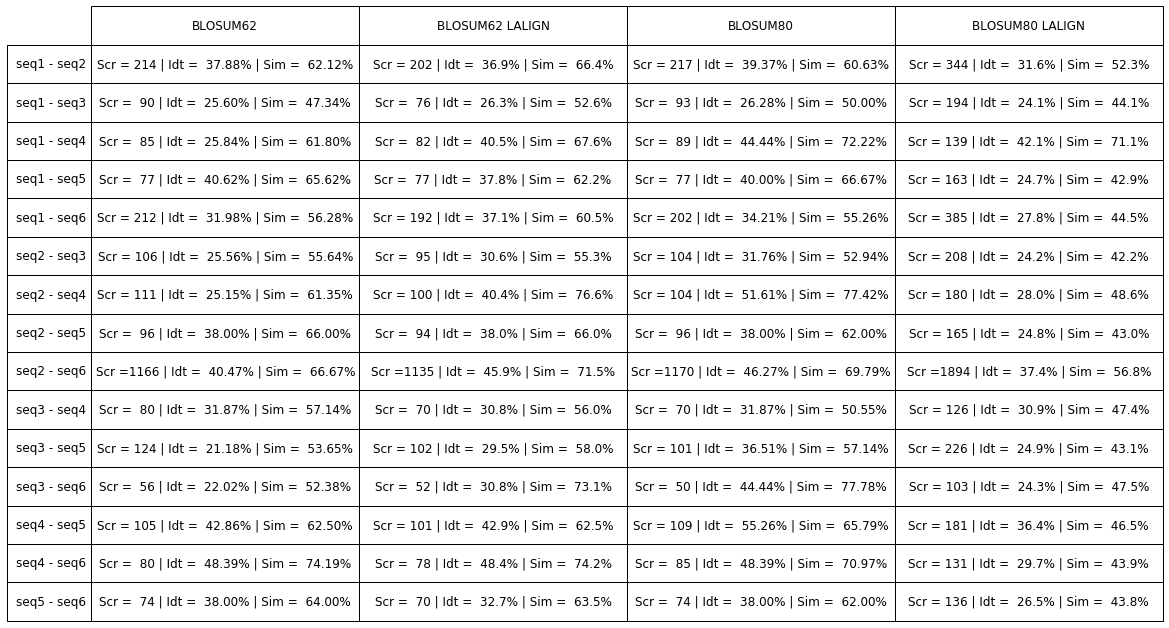

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs =plt.subplots()

col_labels = ["BLOSUM62", "BLOSUM62 LALIGN", "BLOSUM80", "BLOSUM80 LALIGN"]
row_labels = ["seq1 - seq2", "seq1 - seq3", "seq1 - seq4", "seq1 - seq5", "seq1 - seq6", 
              "seq2 - seq3", "seq2 - seq4", "seq2 - seq5", "seq2 - seq6",
              "seq3 - seq4", "seq3 - seq5", "seq3 - seq6",
              "seq4 - seq5", "seq4 - seq6",
              "seq5 - seq6"]


table_vals = [["Scr = 214 | Idt =  37.88% | Sim =  62.12%", "Scr = 202 | Idt =  36.9% | Sim =  66.4%", "Scr = 217 | Idt =  39.37% | Sim =  60.63%", "Scr = 344 | Idt =  31.6% | Sim =  52.3%"],
              ["Scr =  90 | Idt =  25.60% | Sim =  47.34%", "Scr =  76 | Idt =  26.3% | Sim =  52.6%", "Scr =  93 | Idt =  26.28% | Sim =  50.00%", "Scr = 194 | Idt =  24.1% | Sim =  44.1%"],
              ["Scr =  85 | Idt =  25.84% | Sim =  61.80%", "Scr =  82 | Idt =  40.5% | Sim =  67.6%", "Scr =  89 | Idt =  44.44% | Sim =  72.22%", "Scr = 139 | Idt =  42.1% | Sim =  71.1%"],
              ["Scr =  77 | Idt =  40.62% | Sim =  65.62%", "Scr =  77 | Idt =  37.8% | Sim =  62.2%", "Scr =  77 | Idt =  40.00% | Sim =  66.67%", "Scr = 163 | Idt =  24.7% | Sim =  42.9%"],
              ["Scr = 212 | Idt =  31.98% | Sim =  56.28%", "Scr = 192 | Idt =  37.1% | Sim =  60.5%", "Scr = 202 | Idt =  34.21% | Sim =  55.26%", "Scr = 385 | Idt =  27.8% | Sim =  44.5%"],
              ["Scr = 106 | Idt =  25.56% | Sim =  55.64%", "Scr =  95 | Idt =  30.6% | Sim =  55.3%", "Scr = 104 | Idt =  31.76% | Sim =  52.94%", "Scr = 208 | Idt =  24.2% | Sim =  42.2%"],
              ["Scr = 111 | Idt =  25.15% | Sim =  61.35%", "Scr = 100 | Idt =  40.4% | Sim =  76.6%", "Scr = 104 | Idt =  51.61% | Sim =  77.42%", "Scr = 180 | Idt =  28.0% | Sim =  48.6%"],
              ["Scr =  96 | Idt =  38.00% | Sim =  66.00%", "Scr =  94 | Idt =  38.0% | Sim =  66.0%", "Scr =  96 | Idt =  38.00% | Sim =  62.00%", "Scr = 165 | Idt =  24.8% | Sim =  43.0%"],
              ["Scr =1166 | Idt =  40.47% | Sim =  66.67%", "Scr =1135 | Idt =  45.9% | Sim =  71.5%", "Scr =1170 | Idt =  46.27% | Sim =  69.79%", "Scr =1894 | Idt =  37.4% | Sim =  56.8%"],
              ["Scr =  80 | Idt =  31.87% | Sim =  57.14%", "Scr =  70 | Idt =  30.8% | Sim =  56.0%", "Scr =  70 | Idt =  31.87% | Sim =  50.55%", "Scr = 126 | Idt =  30.9% | Sim =  47.4%"],
              ["Scr = 124 | Idt =  21.18% | Sim =  53.65%", "Scr = 102 | Idt =  29.5% | Sim =  58.0%", "Scr = 101 | Idt =  36.51% | Sim =  57.14%", "Scr = 226 | Idt =  24.9% | Sim =  43.1%"],
              ["Scr =  56 | Idt =  22.02% | Sim =  52.38%", "Scr =  52 | Idt =  30.8% | Sim =  73.1%", "Scr =  50 | Idt =  44.44% | Sim =  77.78%", "Scr = 103 | Idt =  24.3% | Sim =  47.5%"],
              ["Scr = 105 | Idt =  42.86% | Sim =  62.50%", "Scr = 101 | Idt =  42.9% | Sim =  62.5%", "Scr = 109 | Idt =  55.26% | Sim =  65.79%", "Scr = 181 | Idt =  36.4% | Sim =  46.5%"],
              ["Scr =  80 | Idt =  48.39% | Sim =  74.19%", "Scr =  78 | Idt =  48.4% | Sim =  74.2%", "Scr =  85 | Idt =  48.39% | Sim =  70.97%", "Scr = 131 | Idt =  29.7% | Sim =  43.9%"],
              ["Scr =  74 | Idt =  38.00% | Sim =  64.00%", "Scr =  70 | Idt =  32.7% | Sim =  63.5%", "Scr =  74 | Idt =  38.00% | Sim =  62.00%", "Scr = 136 | Idt =  26.5% | Sim =  43.8%"]]

the_table = plt.table(cellText=table_vals, rowLabels=row_labels, colLabels=col_labels, loc='center', cellLoc='center')
axs.set_axis_off()
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(3.2, 3.2)
plt.show()

# Conclusion 
Après avoir testé les deux algorithmes d'alignement local et global avec les différents paramètres et matrices de substitutions on peut dire que pour avoir un meilleur alignement il est preferable d'avoir une connaissance sur les deux séquences des protéines qu'on va aligner ou plutôt être conscient des similarités de leur domaine et de leur fonctionnement afin de faciliter la tâche de choisir quelle matrice de substitution est la plus adaptée et avec quels paramètres I et E on doit travailler parce que choisir toujours les valeurs par défaut I = 12 et E = 2 nous ne donne pas toujours les meilleurs alignements possibles donc faut manipuler les variants constamment pour essayer de voir les différences alignements et résultats possibles. 

# Références
[1] https://fr.wikipedia.org/wiki/Alignement_de_s%C3%A9quences <br>
[2] https://fr.wikipedia.org/wiki/Programmation_dynamique  <br>
[3] https://fr.wikipedia.org/wiki/Matrice_de_similarit%C3%A9 <br>
<br>
<br>